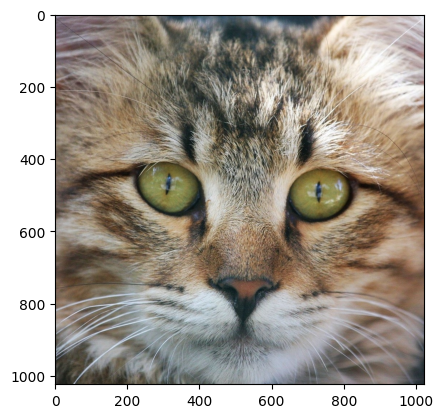

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lovely_tensors as lt
import os
import imageio.v2 as imageio
import numpy as np
import torch
lt.monkey_patch()
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Download image, take a square crop from the center
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
plt.imshow(img)
plt.show()

Shape of xy: torch.Size([64, 2])
First few values of xy:
 tensor[5, 2] n=10 x∈[0.123, 0.897] μ=0.487 σ=0.269 [[0.330, 0.319], [0.519, 0.861], [0.897, 0.205], [0.383, 0.495], [0.742, 0.123]]

Shape of rgb: torch.Size([64, 3])
First few values of rgb:
 tensor[5, 3] n=15 x∈[0.129, 0.941] μ=0.573 σ=0.310


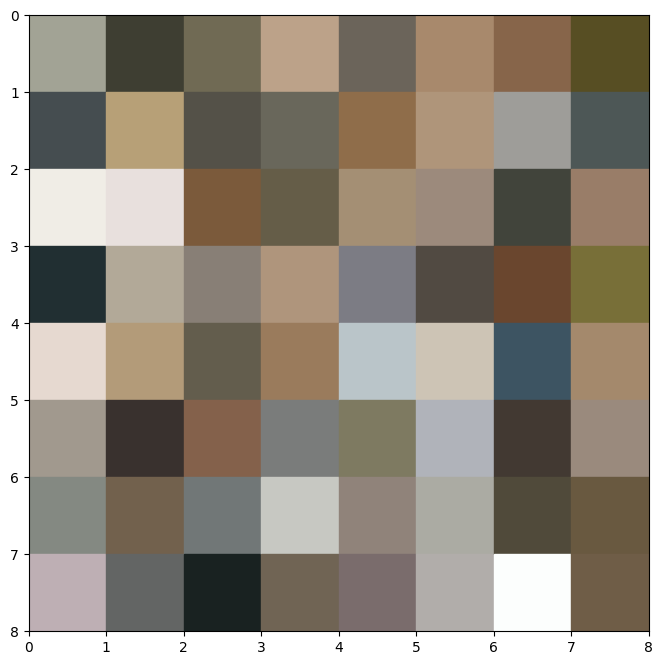

In [2]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img):
        h, w, c = img.shape
        # Create a meshgrid of positions
        x = np.linspace(0, 1, w)
        y = np.linspace(0, 1, h)
        xv, yv = np.meshgrid(x, y)
        positions = np.stack((xv, yv), axis=-1)

        self.X = torch.from_numpy(positions.reshape(-1, 2)).float()  # shape (h*w, 2)
        self.Y = torch.from_numpy(img.reshape(-1, c)).float() / 255.0  # Normalize to [0, 1] range, shape (h*w, 3)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx, :]


dataset = CustomImageDataset(img)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
xy, rgb = next(iter(loader))
xy, rgb
print("Shape of xy:", xy.shape)
print("First few values of xy:\n", xy[:5])

print("\nShape of rgb:", rgb.shape)
print("First few values of rgb:\n", rgb[:5])
plt.figure(figsize=(8,8))
for i in range(8):
    for j in range(8):
        plt.fill([i, i+1, i+1, i], [j, j, j+1, j+1], color=rgb[8*i + j].numpy())  # divide by 255 to bring colors to [0, 1] range
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.gca().invert_yaxis()  # invert y-axis to align with image coordinates
plt.show()


Epoch 100/1000, Loss: 0.3186408281326294, PSNR: 4.966985702514648
Epoch 200/1000, Loss: 0.08071763813495636, PSNR: 10.930315017700195
Epoch 300/1000, Loss: 0.020673858001828194, PSNR: 16.84578514099121
Epoch 400/1000, Loss: 0.0052917697466909885, PSNR: 22.763992309570312
Epoch 500/1000, Loss: 0.0013472590362653136, PSNR: 28.705490112304688
Epoch 600/1000, Loss: 0.0003402496222406626, PSNR: 34.68202209472656
Epoch 700/1000, Loss: 8.505726145813242e-05, PSNR: 40.70288848876953
Epoch 800/1000, Loss: 2.1001076675020158e-05, PSNR: 46.77758026123047
Epoch 900/1000, Loss: 5.10872496306547e-06, PSNR: 52.916873931884766
Epoch 1000/1000, Loss: 1.2208903399368864e-06, PSNR: 59.13323211669922


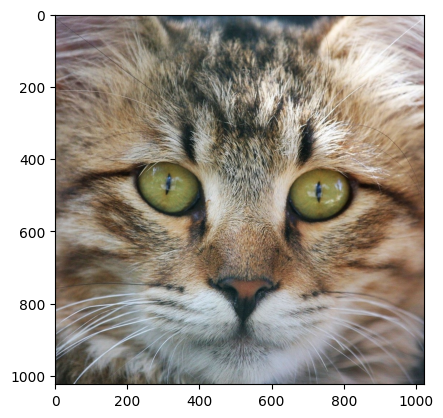

In [8]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Function to calculate Peak Signal-to-Noise Ratio (PSNR)
def psnr(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2)
    max_pixel = 1.0  # Assuming the pixel range of the image is [0, 1]
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

# Load the original image
original_image = img

# Preprocess the original image and convert it to a PyTorch tensor
preprocess = transforms.ToTensor()
original_tensor = preprocess(original_image).unsqueeze(0)

# Create a randomly initialized tensor for image reconstruction
reconstructed_tensor = torch.randn(original_tensor.size(), requires_grad=True)

# Define the Mean Squared Error (MSE) loss
criterion = torch.nn.MSELoss()

# Create an Adam optimizer for optimizing the reconstructed tensor
optimizer = optim.Adam([reconstructed_tensor], lr=0.01)

# Number of training epochs
num_epochs = 1000

# Lists to store losses and PSNR values
losses = []
psnr_values = []

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Calculate the loss between the reconstructed tensor and the original tensor
    loss = criterion(reconstructed_tensor, original_tensor)

    # Calculate PSNR and save it
    with torch.no_grad():
        psnr_value = psnr(original_tensor, reconstructed_tensor)
    psnr_values.append(psnr_value.item())

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Save the loss value
    losses.append(loss.item())

    # Print the loss and PSNR
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, PSNR: {psnr_value.item()}")

# Convert the reconstructed tensor to an image
reconstructed_image = transforms.ToPILImage()(reconstructed_tensor.squeeze())
plt.imshow(reconstructed_image)
plt.show()